In [1]:
#Importing required packages
import pypsa
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib as mpl
from shapely.geometry import Point


Specify your own file path for the network below

In [2]:
# Path to your solved network. 
network_path = r"C:\Users\aleks\Documents\UsN\FM4017 - Project\FM4017-Project Repo Aleks\FM4017-Project\pypsa-eur\resources\NordicWeightedZones2023ExDC\networks\base_s_65_elec_.nc"
# Load it, such that it is saved in n
n = pypsa.Network(network_path)

# Check network info
print(n)


INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, lines, links, loads, storage_units, stores


PyPSA Network 'Unnamed Network'


Defining functions to be used later

In [3]:
"""
Defining a plotting function for simple visual verification of network modifications to be done later in code
"""

def plot_network_map(nw, title="Network Map"):
    """
    Plot a PyPSA network with bus loadings, line & link capacities,
    showing coordinate axes and gridlines every 0.5°.
    """

    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import numpy as np

    # --- Compute bus loading ---
    bus_loading = nw.loads_t.p.sum(axis=0)
    bus_loading = bus_loading.reindex(nw.buses.index).fillna(0)

    # --- Compute line widths ---
    if not nw.lines.empty:
        line_capacities = nw.lines.s_nom.copy()
        line_widths = 0.1 + 8 * line_capacities / line_capacities.max()
    else:
        line_widths = None

    # --- Compute link widths ---
    if not nw.links.empty:
        link_capacities = nw.links.p_nom.copy()
        link_widths = 0.1 + 4 * link_capacities / link_capacities.max()
    else:
        link_widths = None

    # --- Create GeoAxes ---
    fig = plt.figure(figsize=(15, 15))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Optional: add borders, coastlines, etc.
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.add_feature(cfeature.COASTLINE)

    # --- Plot network ---
    nw.plot(
        ax=ax,
        bus_colors=bus_loading,
        bus_sizes=0.01,
        line_alpha=1,
        line_widths=line_widths,
        link_alpha=1,
        link_widths=link_widths,
    )

    # --- Add gridlines every 0.5° ---
    gl = ax.gridlines(
        draw_labels=True,
        linewidth=0.5,
        color='gray',
        alpha=0.6,
        linestyle='--'
    )
    gl.top_labels = False
    gl.right_labels = False

    # Force grid spacing to 0.5° increments
    lon_min, lon_max = ax.get_extent(crs=ccrs.PlateCarree())[0:2]
    lat_min, lat_max = ax.get_extent(crs=ccrs.PlateCarree())[2:4]

    gl.xlocator = plt.FixedLocator(np.arange(np.floor(lon_min), np.ceil(lon_max) + 0.5, 0.5))
    gl.ylocator = plt.FixedLocator(np.arange(np.floor(lat_min), np.ceil(lat_max) + 0.5, 0.5))

    ax.set_xlabel("Longitude [°E]")
    ax.set_ylabel("Latitude [°N]")

    # --- Add colorbar ---
    sm = plt.cm.ScalarMappable(
        cmap=plt.cm.viridis,
        norm=plt.Normalize(vmin=bus_loading.min(), vmax=bus_loading.max())
    )
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.7)
    cbar.set_label("Total Load [MW]")

    plt.title(title)
    plt.show()



#Defining function for plotting bidding zones. 
def plot_network_with_bidding_zones(n, link_widhts_C = 0.1, line_widhts_C = 0.1, geojson_path=r"C:\Users\aleks\Documents\UsN\FM4017 - Project\FM4017-Project Repo Aleks\FM4017-Project\pypsa-eur\resources\NordicWeightedZonesTestDCLinksx\bidding_zones.geojson"):
    """
    Plots a PyPSA network with bidding zones, bus loading, line and link capacities.

    Parameters
    ----------
    n : pypsa.Network
        The PyPSA network object.
    geojson_path : str, optional
        Path to the bidding zones GeoJSON file.
    """

    # Load the bidding zones GeoJSON
    zones_gdf = gpd.read_file(geojson_path)

    # Compute total bus loading (sum over all time steps)
    bus_loading = n.loads_t.p.sum(axis=0)  # MW per bus

    # Extract line capacities
    line_capacities = n.lines.s_nom.copy()
    line_widths = line_widhts_C  + 4 * line_capacities / line_capacities.max()

    # Extract link capacities (if present)
    if not n.links.empty:
        link_capacities = n.links.p_nom.copy()
        link_widths = link_widhts_C + 4 * link_capacities / link_capacities.max()
    else:
        link_widths = None

    # --- Create plot ---
    fig = plt.figure(figsize=(15, 15))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Plot bidding zones
    zones_gdf.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=1)

    # Plot the network
    n.plot.map(ax=ax,
               bus_colors=bus_loading,
               bus_sizes=0.01,
               line_alpha=1,
               line_widths=line_widths,
               link_alpha=1,
               link_widths=link_widths)

    # Add colorbar for bus loadings
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis,
                               norm=plt.Normalize(vmin=bus_loading.min(),
                                                  vmax=bus_loading.max()))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.7)
    cbar.set_label("Total Load [MW]")

    plt.title("PyPSA Network with Bidding Zones, Bus Loading, Line & Link Capacities")
    plt.show()


#Function for assigning bidding zones from geojson
def assign_bidding_zones(n, zones_path=r"C:\Users\aleks\Documents\UsN\FM4017 - Project\FM4017-Project Repo Aleks\FM4017-Project\pypsa-eur\resources\NordicWeightedZonesTestDCLinksx\bidding_zones.geojson"):
    # Load the bidding zones polygons
    zones_gdf = gpd.read_file(zones_path)

    # Convert buses to GeoDataFrame with Point geometry
    bus_gdf = gpd.GeoDataFrame(
        n.buses.copy(),
        geometry=gpd.points_from_xy(n.buses.x, n.buses.y),
        crs=zones_gdf.crs
    )

    # Spatial join: assign each bus the zone it falls into
    bus_with_zone = gpd.sjoin(bus_gdf, zones_gdf, how="left", predicate="within")

    # Map from Norwegian subzones to official bidding zones
    norway_zone_map = {
        "NOS1": "NO1",
        "NOS2": "NO2",
        "NOS5": "NO5",
        "NOM1": "NO3",
        "NON1": "NO4"
    }

    # First assign subzones from the geojson
    n.buses["subzone"] = bus_with_zone["zone_name"]

    # Then map to bidding zones
    n.buses["zone"] = n.buses["subzone"].map(norway_zone_map).fillna(n.buses["subzone"])


#Function for adding links with modification from DF

def add_link_from_df(df_links, new_network, row_index, new_bus0, new_bus1, new_name):
    """
    Add a link from a given row index of df_links to a new PyPSA network,
    with new bus0, bus1, and link name.
    """
    import numpy as np

    link_data = df_links.iloc[row_index]

    p_nom = link_data.get('p_nom', 0)
    efficiency = link_data.get('efficiency', np.nan)
    length = link_data.get('length', np.nan)
    carrier = link_data.get('carrier', 'DC')

    for bus in [new_bus0, new_bus1]:
        if bus not in new_network.buses.index:
            new_network.add("Bus", name=bus, v_nom=220)
            print(f"🟢 Added missing bus: {bus}")

    new_network.add(
        "Link",
        name=new_name,
        bus0=new_bus0,
        bus1=new_bus1,
        p_nom=p_nom,
        efficiency=efficiency if not np.isnan(efficiency) else 1.0,
        length=length if not np.isnan(length) else 0,
        carrier=carrier
    )

    print(f"✅ Added link '{new_name}' ({new_bus0} → {new_bus1}, {p_nom} MW)")
    return new_network




In [4]:
#Add a filepath if you are not Aleksander in the function below. See cell above for args. 
assign_bidding_zones(n)

In [5]:
#clean_nordic_network(n)
#plot_network_with_bidding_zones(n)

In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', None)
#display(n.buses)

Adding Buses in Europe with coords based on ENTSO grid kit. Visual check using https://www.gps-coordinates.net/map/country/GB. 

In [7]:
n.add(
    "Bus",
    name="GB",          # unique bus name
    v_nom=380,           # nominal voltage level (kV)
    y=55.024016741590025,              
    x=-1.4325595910123567,              
    carrier="AC"         # AC or DC bus type
)

n.add(
    "Bus",
    name="NL",          # unique bus name
    v_nom=380,           # nominal voltage level (kV)
    y=53.45168065250071,              
    x=6.798961509497912,              
    carrier="AC"         # AC or DC bus type
)

n.add(
    "Bus",
    name="DE",          # unique bus name
    v_nom=380,           # nominal voltage level (kV)
    y=54.07611776227856,              
    x=10.02805057158303,              
    carrier="AC"         # AC or DC bus type
)

n.add(
    "Bus",
    name="PL",          # unique bus name
    v_nom=380,           # nominal voltage level (kV)
    y=54.533292698968296,              
    x=16.85784524633093,              
    carrier="AC"         # AC or DC bus type
)

n.add(
    "Bus",
    name="LT",          # unique bus name
    v_nom=380,           # nominal voltage level (kV)
    y=55.7127529,              
    x=21.1350469,              
    carrier="AC"         # AC or DC bus type
)

n.add(
    "Bus",
    name="EE",          # unique bus name
    v_nom=380,           # nominal voltage level (kV)
    y=59.385532,              
    x=24.5826355,              
    carrier="AC"         # AC or DC bus type
)

Index(['EE'], dtype='object')

In [14]:
df_links  = pd.read_pickle(r"C:\Users\aleks\Documents\UsN\FM4017 - Project\FM4017-Project Repo Aleks\FM4017-Project\links.pkl")


In [16]:
#Adding links from dataframe from previous model and changing name and connection points. Perhaps this could be done in a better way idk. 
add_link_from_df(df_links, n, 0, "NO1 22", "GB", "North Sea Link")
add_link_from_df(df_links, n, 1, "NO1 25", "DE", "NO-DE link")
add_link_from_df(df_links, n, 2, "DK1 0", "DE", "DE-DK Link")

add_link_from_df(df_links, n, 5, "SE1 5", "PL", "SE-PL Link")

add_link_from_df(df_links, n, 10, "FI1 5", "EE", "FI-EE Link")

add_link_from_df(df_links, n, 14, "SE1 17", "LT", "SE-LT Link")
add_link_from_df(df_links, n, 15, "NO1 25", "NL", "NO-NL Link")
add_link_from_df(df_links, n, 15, "SE1 0", "DE", "SE-DE Link")

#Alterning P_nom for Finland Estonia link, as we only use 1 link:
n.links.at["FI-EE Link", "p_nom"] = 1000


✅ Added link 'North Sea Link' (NO1 22 → GB, 1400.0 MW)
✅ Added link 'NO-DE link' (NO1 25 → DE, 1400.0 MW)
✅ Added link 'DE-DK Link' (DK1 0 → DE, 600.0 MW)
✅ Added link 'SE-PL Link' (SE1 5 → PL, 600.0 MW)
✅ Added link 'FI-EE Link' (FI1 5 → EE, 350.0 MW)
✅ Added link 'SE-LT Link' (SE1 17 → LT, 700.0 MW)
✅ Added link 'NO-NL Link' (NO1 25 → NL, 700.0 MW)
✅ Added link 'SE-DE Link' (SE1 0 → DE, 700.0 MW)


In [17]:
#Verifying that P_nom = 1000 MW from FI to EE
n.links.at["FI-EE Link", "p_nom"]

1000.0

C:\Users\aleks\AppData\Local\Temp\ipykernel_65792\3407870377.py:43: DeprecatedWarning:

plot is deprecated as of 0.34 and will be removed in 1.0. Use `n.plot.map()` as a drop-in replacement instead.



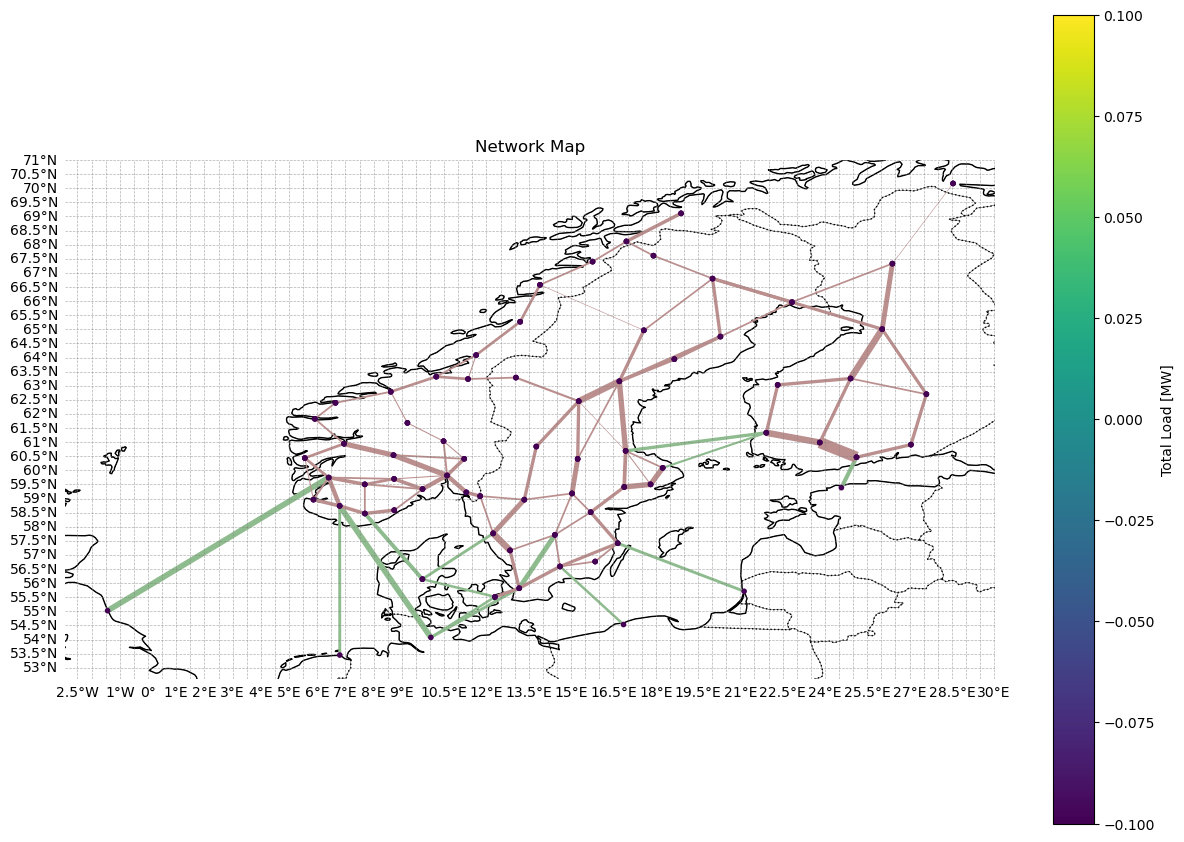

In [18]:
plot_network_map(n)

In [19]:
#n.links

In [20]:
#n.lines